# Recurrent Neural Networks

We'll introduce the concept of recurrent neural networks, which explicitly model the time-dependency of their inputs to facilitate the analysis of sequential data. We'll demonstrate this functionality using a weather forecasting dataset in a classic time-series analysis approach.


# Implement a Simple Recurrent Neural Network

We start with an example implementing the feed-forward pass of a recurrent neural network in NumPy. To keep things simple, we assume that the signal is a scalar value containing a single feature, corresponding to a binary signal. 


We can use a recurrent relation to implement a feedback comb filter.

In [ ]:
input_series = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
output_series = []

state = 0
U = 1 / 2
V = 1 - U
for input_data in input_series:
    hidden = U * input_data + V * state
    output_data = hidden
    state = output_data
    output_series.append(output_data)

print(f"Input Series: {[f'{x:.2f}' for x in input_series]}")
print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

In [ ]:
from matplotlib import pyplot as plt

plt.plot(input_series, label="input signal")
plt.plot(output_series, label="output signal")
plt.legend()
plt.show()

We modify the previous code to implement a more general recurrent neuron.

In [ ]:
import numpy as np


def sigmoid(x):
    """Simple implementation of sigmoid function."""
    return 1 / (1 + np.exp(-x))


input_series = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
output_series = []

state = 0
U, V, W, b = np.random.normal(size=4)
for input_data in input_series:
    hidden = sigmoid(U * input_data + V * state + b)
    output_data = sigmoid(hidden * W)
    state = output_data
    output_series.append(output_data)

print(f"Input Series: {[f'{x:.2f}' for x in input_series]}")
print(f"Output Series: {[f'{x:.2f}' for x in output_series]}")

## Load Weather Dataset

We download the uncompressed dataset of the Jena Climate Dataset from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

More information on this dataset can be found at https://www.bgc-jena.mpg.de/wetter/.

In [ ]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

dataset_path = os.path.join(".", "weather_dataset")
if not os.path.exists(dataset_path):
    url = "https://s3.amazonaws.com/keras-datasets/" "jena_climate_2009_2016.csv.zip"
    download_url(url, ".")
    _extract_zip("jena_climate_2009_2016.csv.zip", dataset_path, None)
    os.remove("jena_climate_2009_2016.csv.zip")

This dataset contains 14 weather measurements in a `.csv` file. Their meaning is shown in the header.

In [ ]:
# import csv
# import numpy as np

# filename = os.path.join(dataset_path, "jena_climate_2009_2016.csv")
# with open(filename) as f:
#     reader = csv.reader(f)
#     header = next(reader)
#     data = []
#     for row in reader:
#         data.append(row[1:])  # The first value ("Date Time") is excluded.
#     data = np.asarray(data).astype(float)

# print(header)

In [ ]:
import pandas as pd

filename = os.path.join(dataset_path, "jena_climate_2009_2016.csv")
dataframe = pd.read_csv(filename, index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()
dataframe.head()

## Visualize Data

We now visualize the 14 measured features of the dataset. For this, we use the `plot_data()` function.

```python
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, header, start=0, samples_per_cycle=144, cycles=14):
    """Plot data highlighting periodic cycles."""

    fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)

    for i, ax in enumerate(axes.flatten()):
        ax.plot(np.arange(start, start + samples_per_cycle * cycles),
                data[start:start + samples_per_cycle * cycles, i], 
                label=header[i])
        ax.legend()
        ax.set_xlim(start, start + samples_per_cycle * cycles)
        
        for cycle in range(1, cycles):
            ax.axvline(x=start + cycle * samples_per_cycle, 
                    color="gray", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()
```

In [ ]:
from for_rnn import plot_data

daily_samples = 144
n_days = 14

plot_data(data, header, samples_per_cycle=daily_samples, cycles=n_days)

## Preprocess Data

We start by removing the mean from the data and normalizing them by their standard deviation.

In [ ]:
data -= data.mean(axis=0)
data /= data.std(axis=0)

plot_data(data, header, samples_per_cycle=daily_samples, cycles=n_days)

We now preprocess the data into time series to input into the neural network model, that is, they need to be of shape (batch size, number of samples, number of feature).

In [ ]:
n_samples = data.shape[0]
n_features = data.shape[1]
pred_window = 288  # Length of the sequences to be fed to the RNN.
pred_lag = pred_window + 72
# How many time_steps ahead in time the RNN should predict temperature. 1 very easy. 18 used for course. 144 = 1 day
temp_idx = 2  # Temperature index.

inputs, targets = [], []
for i in np.random.permutation(range(0, n_samples - pred_lag, pred_window)):
    inputs.append(data[i : i + pred_window, :])
    targets.append(data[i + pred_lag : i + pred_lag + 1, temp_idx])
inputs = np.asarray(inputs)
targets = np.asarray(targets)

print(inputs.shape)
print(targets.shape)

We start by creating a dataset and the respective data loaders.

In [ ]:
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader

# Convert to PyTorch tensors.
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

# Splitting the dataset into training and validation
dataset = TensorDataset(inputs_tensor, targets_tensor)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Creating a Common-Sense Benchmark

We then create a baseline common-sense benchmark, generate benchmark for comparison, i.e., predict $T_t = T_{t-1}$.

In [ ]:
temperature = data[:, temp_idx]
benchmark = np.mean(
    np.abs(
        temperature[daily_samples::daily_samples]
        - temperature[:-daily_samples:daily_samples]
    )
)

print(benchmark)

## Implement PyTorch RNN Model

This example introduces the `RNN` module in PyTorch.

In [ ]:
import torch.nn as nn

# Define the RNN and Linear layers separately.
rnn = nn.RNN(input_size=inputs.shape[2], hidden_size=2, batch_first=True)
fc = nn.Linear(in_features=2, out_features=1)

We now train the model.

In [ ]:
criterion = nn.L1Loss()  # MAE loss.
optimizer = torch.optim.Adam(
    list(rnn.parameters()) + list(fc.parameters()), lr=0.001
)  # Optimizer.
epochs = 100

train_losses, val_losses = [], []
for epoch in range(epochs):
    # Training.
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        rnn_out, _ = rnn(inputs)  # RNN layer.
        rnn_out = rnn_out[:, -1, :]  # Select the last output for each sequence.
        outputs = fc(rnn_out)  # Linear layer.

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")

    # Validation.
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            rnn_out, _ = rnn(inputs)  # RNN layer.
            rnn_out = rnn_out[:, -1, :]  # Selecting the last output for each sequence.
            outputs = fc(rnn_out)  # Linear layer.

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

We then validate the model for which we write the `plot_training()` function.

```python
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], 
            linestyle="--", color="k", label="Benchmark")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim([0, epochs - 1])
    plt.show()
```

In [ ]:
from for_rnn import plot_training

plot_training(epochs, train_losses, val_losses, benchmark)

## Implement the RNN in Deeplay

We now implement the RNN in deeplay.

In [19]:
class myRegressor(dl.Application):
    model: torch.nn.Module
    loss: torch.nn.Module
    metrics: list
    optimizer: dl.Optimizer

    def __init__(
        self,
        model: torch.nn.Module,
        loss: torch.nn.Module = torch.nn.L1Loss(),
        optimizer=None,
        **kwargs,
    ):
        super().__init__(loss=loss, **kwargs)

        self.model = model
        self.optimizer = optimizer or Adam(lr=1e-3)

        @self.optimizer.params
        def params(self):
            return self.model.parameters()

    def validation_step(self, batch, batch_idx):
        x, y = self.val_preprocess(batch)
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        if not isinstance(loss, dict):
            loss = {"loss": loss}

        for name, v in loss.items():
            self.log(
                f"val_{name}",
                v,
                on_step=True,
                on_epoch=True,
                prog_bar=False,
                logger=True,
            )
        self.log_metrics(
            "val",
            y_hat,
            y,
            on_step=True,
            on_epoch=True,
            prog_bar=False,
            logger=True,
        )
        return sum(loss.values())

    def forward(self, x):
        return self.model(x)

In [20]:
import deeplay as dl

rnn = dl.RecurrentModel(
    in_features=14,
    hidden_features=[2],
    out_features=1,
    rnn_type="RNN",
    dropout=0,
)
rnn_simple = myRegressor(rnn, optimizer=dl.Adam(lr=0.001)).create()

print(rnn_simple)

myRegressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RecurrentModel(
    (blocks): LayerList(
      (0): RecurrentBlock(
        (layer): RNN(14, 2, batch_first=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): RecurrentDropout(
          (dropout): Dropout(p=0, inplace=False)
        )
      )
      (1): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=2, out_features=1, bias=True)
        (activation): Identity()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (optimizer): Adam[Adam](lr=0.001)
)


We write a `TrainingHistory` class to implement a custom callback for use with the PyTorch Lightning framework, designed to track and store the training and validation losses at the end of each epoch. We save also this one in `for_rnn.py`.

```python
class TrainingHistory(Callback):
    """Callback to record the training and validation losses."""

    def on_train_start(self, trainer, pl_module):
        """Initialize lists to store loss values."""
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        """Store training and validation losses."""

        train_loss = trainer.callback_metrics.get(
            "train_loss"
        )  # Retrieve the training loss from the current epoch.
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

        val_loss = trainer.callback_metrics.get(
            "val_loss"
        )  # Retrieve the validation loss from the current epoch.
        if val_loss is not None:
            self.val_losses.append(val_loss.item()))
```

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RecurrentModel   | 39    
5 | optimizer     | Adam             | 0     
---------------------------------------------------
39        Trainable params
0         Non-trainable params
39        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the traini

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


ValueError: x and y must have same first dimension, but have shapes (100,) and (14,)

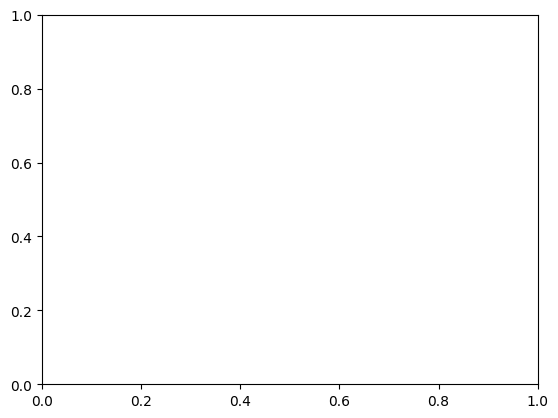

In [21]:
from for_rnn import TrainingHistory

history = TrainingHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[history], accelerator="auto")

trainer.fit(rnn_simple, train_loader, val_loader)
plot_training(epochs, history.train_losses, history.val_losses, benchmark)

### Stacked RNN

In [ ]:
rnn = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 32, 32, 32],
    out_features=1,
    rnn_type="RNN",
)
stacked_rnn = dl.Regressor(rnn, optimizer=dl.Adam(lr=0.001)).create()

print(stacked_rnn)

In [ ]:
history = TrainingHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[history], accelerator="auto")
trainer.fit(stacked_rnn, train_loader, val_dataloaders=val_loader)
plot_training(epochs, history.train_losses, history.val_losses, benchmark)

### Stacked GRU

In [ ]:
rnn = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 32, 32, 32],
    out_features=1,
    rnn_type="GRU",
)
gru = dl.Regressor(rnn, optimizer=dl.Adam(lr=0.001)).create()

print(model)

In [ ]:
history = TrainingHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[history], accelerator="auto")
trainer.fit(gru, train_loader, val_dataloaders=val_loader)
plot_training(epochs, history.train_losses, history.val_losses, benchmark)

### Stacked LSTM

In [ ]:
rnn = dl.RNN(
    in_features=n_features,
    hidden_features=[32, 32, 32, 32],
    out_features=1,
    rnn_type="LSTM",
)
model = dl.Regressor(rnn, optimizer=dl.Adam(lr=0.001)).create()

print(model)

In [ ]:
history = TrainingHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[history], accelerator="auto")
trainer.fit(model, train_loader, val_dataloaders=val_loader)
plot_training(epochs, history.train_losses, history.val_losses, benchmark)

### Introducing Dropout

We now introduce dropout to prevent overfitting.

In [ ]:
rnn_dropout = dl.RNN(
    in_features=n_features,
    hidden_features=[32, 32, 32, 32],
    out_features=1,
    rnn_type="RNN",  # HENRIK: Can this just be set up here as "LSTM"?
)
rnn_dropout.blocks[:-1].layer.configure(torch.nn.LSTM)
rnn_dropout.blocks.dropout.configure(p=0.2)
model_dropout = dl.Regressor(rnn_dropout).create()

print(model_dropout)

history_dropout = TrainingHistory()

trainer_dropout = dl.Trainer(
    max_epochs=epochs,
    callbacks=[history_dropout],
    accelerator="auto",
)
trainer_dropout.fit(model_dropout, train_loader, val_dataloaders=val_loader)

plot_training(
    epochs,
    history_dropout.train_losses,
    history_dropout.val_losses,
    benchmark,
)

## Implementing a Preprocessor

We now introduce a dense preprocessor in feature space.

In [ ]:
preprocessor = dl.MultiLayerPerceptron(
    in_features=None, hidden_features=[32, 32], out_features=32
)
preprocessor.dropout.configure(p=0.2)


class Reshape(nn.Module):  # HENRIK, shouldn't this be deeplay layer?
    """Custom reshape layer."""

    def __init__(self, new_shape):
        """Custom reshape layer."""
        super(Reshape, self).__init__()
        self.new_shape = new_shape

    def forward(self, x):
        """Define the forward pass for the reshape layer."""
        return x.view(self.new_shape)


rnn_preprocessed = dl.Sequential(
    torch.nn.Flatten(
        start_dim=0, end_dim=1
    ),  # HENRIK, shouldn't this be included in a deeplay layer?
    preprocessor,
    Reshape(
        (-1, pred_window, 32)
    ),  # HENRIK, shouldn't this be included in a deeplay layer?
    dl.RNN(
        in_features=32,
        hidden_features=[32, 32, 32, 32],
        out_features=1,
        dropout=0.2,  # HENRIK: This doesn't seem to work. Please, double-check.
        rnn_type="LSTM",
    ),
)
model_preprocessed = dl.Regressor(rnn_preprocessed).create()

print(model_preprocessed)

history_preprocessed = TrainingHistory()

trainer_preprocessed = dl.Trainer(
    max_epochs=epochs,
    callbacks=[history_preprocessed],
    accelerator="auto",
)
trainer_preprocessed.fit(model_preprocessed, train_loader, val_dataloaders=val_loader)

plot_training(
    epochs,
    history_preprocessed.train_losses,
    history_preprocessed.val_losses,
    benchmark,
)